# Model Output Examination

This notebook allows you to examine the outputs of each friction model (M1-M6) for the XL330 motor.

**Usage:** In each model section, edit the `kp`, `trajectory`, and `params_file` variables, then run the cell.

In [76]:
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.insert(0, '.')

from bam.model import load_model, DummyModel, models
from bam.actuators import actuators
from bam import simulate
from bam import logs as logs_module

In [77]:
# Configuration
OUTPUT_DIR = "output"
LOG_DIR = "processed_data"
ACTUATOR = "xl330"

# Load all logs
all_logs = logs_module.Logs(LOG_DIR)
print(f"Loaded {len(all_logs.logs)} log files")

# Show available options
all_kps = sorted(set(log['kp'] for log in all_logs.logs))
all_trajectories = sorted(set(log['trajectory'] for log in all_logs.logs))
print(f"\nAvailable kp values: {all_kps}")
print(f"Available trajectories: {all_trajectories}")

# Load all params files grouped by model
model_params = {}
for model_name in ['m1', 'm2', 'm3', 'm4', 'm5', 'm6']:
    params_files = sorted(glob.glob(f"{OUTPUT_DIR}/params_*.json"))
    model_params[model_name] = [pf for pf in params_files if json.load(open(pf)).get('model') == model_name]
    print(f"{model_name}: {[p.split('/')[-1] for p in model_params[model_name]]}")

Loaded 12 log files

Available kp values: [200, 300, 400]
Available trajectories: ['lift_and_drop', 'sin_sin', 'sin_time_square', 'up_and_down']
m1: ['params_1.json', 'params_2.json', 'params_3.json']
m2: ['params_4.json', 'params_5.json', 'params_6.json']
m3: ['params_7.json', 'params_8.json', 'params_9.json']
m4: ['params_10.json', 'params_11.json', 'params_12.json']
m5: ['params_13.json', 'params_14.json', 'params_15.json']
m6: ['params_16.json', 'params_17.json', 'params_18.json']


In [78]:
def get_log(kp, trajectory):
    """Get the first log matching kp and trajectory."""
    for log in all_logs.logs:
        if log['kp'] == kp and log['trajectory'] == trajectory:
            return log
    return None

def compute_rmse(log, model):
    """Compute RMSE between actual and simulated positions."""
    simulator = simulate.Simulator(model)
    sim_q, _, _ = simulator.rollout_log(log, reset_period=None, simulate_control=True)
    q = [e['position'] for e in log['entries']]
    err = np.array(q) - np.array(sim_q)
    return np.sqrt(np.mean(err**2))

def plot_model(log, model):
    """Plot actual vs simulated data."""
    simulator = simulate.Simulator(model)
    sim_q, sim_speed, sim_controls = simulator.rollout_log(log, reset_period=None, simulate_control=True)
    
    ts = np.arange(len(log['entries'])) * log['dt']
    q = [e['position'] for e in log['entries']]
    goal_q = [e['goal_position'] for e in log['entries']]
    speed = [e.get('speed', 0.0) for e in log['entries']]
    
    dummy = DummyModel()
    dummy.set_actuator(actuators[ACTUATOR]())
    dummy_sim = simulate.Simulator(dummy)
    _, __, controls = dummy_sim.rollout_log(log, simulate_control=False)
    torque_enable = [e['torque_enable'] for e in log['entries']]
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 10))
    
    ax1.plot(ts, q, label='Actual', lw=2)
    ax1.plot(ts, goal_q, label='Goal', color='black', ls='--', alpha=0.7)
    ax1.plot(ts, sim_q, label=f'{model.name} sim', lw=2, alpha=0.8)
    ax1.legend()
    ax1.set_title(f'{model.title}: {log["trajectory"]}, kp={log["kp"]}, m={log["mass"]}, l={log["length"]}')
    ax1.set_ylabel('Angle [rad]')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(ts, speed, label='Actual', lw=2)
    ax2.plot(ts, sim_speed, label=f'{model.name} sim', lw=2, alpha=0.8)
    ax2.set_ylabel('Speed [rad/s]')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    ax3.plot(ts, controls, label='Control', lw=2)
    ax3.plot(ts, sim_controls, label=f'{model.name} sim', lw=2, alpha=0.8)
    ctrl_vals = [0.0 if c is None else c for c in controls]
    ax3.fill_between(ts, min(ctrl_vals)-0.02, max(ctrl_vals)+0.02,
                     where=[not t for t in torque_enable], color='red', alpha=0.3, label='Torque off')
    ax3.set_ylabel(dummy.actuator.control_unit())
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.xlabel('Time [s]')
    plt.tight_layout()
    plt.show()
    
    err = np.array(q) - np.array(sim_q)
    print(f"RMSE: {np.sqrt(np.mean(err**2)):.4f} rad | MAE: {np.mean(np.abs(err)):.4f} rad")

---
# Error Analysis Across Models, KP, and Trajectories

Compute RMSE for all combinations and visualize the differences.

In [79]:
# Compute RMSE for all model/kp/trajectory combinations
# Using the first params file for each model

results = []

for model_name in ['m1', 'm2', 'm3', 'm4', 'm5', 'm6']:
    if not model_params[model_name]:
        continue
    params_file = model_params[model_name][0]  # Use first params file
    model = load_model(params_file)
    
    for kp in all_kps:
        for traj in all_trajectories:
            log = get_log(kp, traj)
            if log:
                rmse = compute_rmse(log, model)
                results.append({
                    'model': model_name.upper(),
                    'kp': kp,
                    'trajectory': traj,
                    'rmse': rmse,
                    'rmse_deg': np.degrees(rmse)
                })

df = pd.DataFrame(results)
print(f"Computed {len(df)} RMSE values")
df

Computed 72 RMSE values


,model,kp,trajectory,rmse,rmse_deg
0,M1,200,lift_and_drop,0.070180,4.021043
1,M1,200,sin_sin,0.103810,5.947864
2,M1,200,sin_time_square,0.241667,13.846526
3,M1,200,up_and_down,0.053141,3.044742
4,M1,300,lift_and_drop,0.051193,2.933120
...,...,...,...,...,...
67,M6,300,up_and_down,0.023971,1.373420
68,M6,400,lift_and_drop,0.032250,1.847773
69,M6,400,sin_sin,0.054971,3.149621
70,M6,400,sin_time_square,0.297091,17.022063


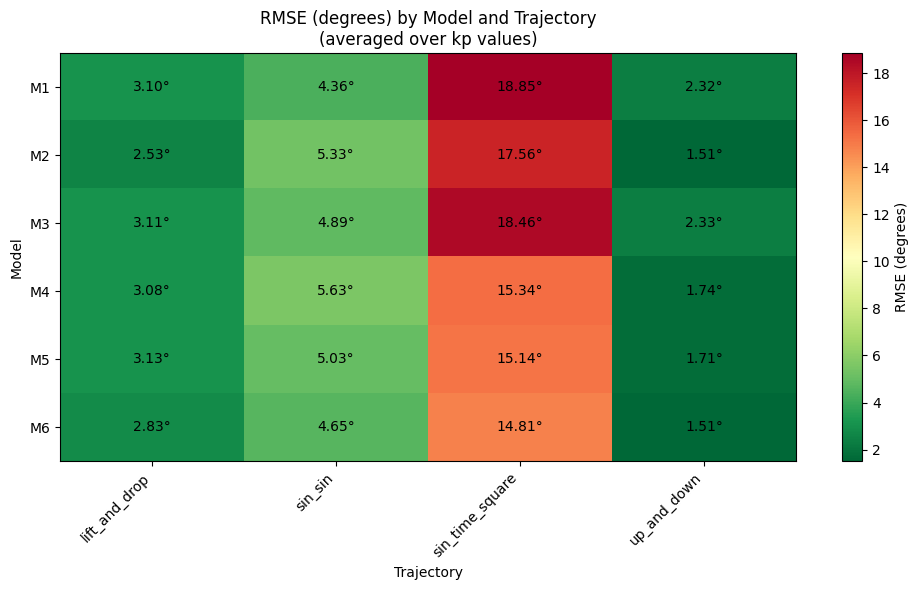

In [80]:
# Heatmap: RMSE by Model vs Trajectory (averaged over kp)
pivot_traj = df.pivot_table(values='rmse_deg', index='model', columns='trajectory', aggfunc='mean')
pivot_traj = pivot_traj.reindex(['M1', 'M2', 'M3', 'M4', 'M5', 'M6'])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(pivot_traj.values, cmap='RdYlGn_r', aspect='auto')
ax.set_xticks(range(len(pivot_traj.columns)))
ax.set_xticklabels(pivot_traj.columns, rotation=45, ha='right')
ax.set_yticks(range(len(pivot_traj.index)))
ax.set_yticklabels(pivot_traj.index)
ax.set_xlabel('Trajectory')
ax.set_ylabel('Model')
ax.set_title('RMSE (degrees) by Model and Trajectory\n(averaged over kp values)')

# Add text annotations
for i in range(len(pivot_traj.index)):
    for j in range(len(pivot_traj.columns)):
        val = pivot_traj.values[i, j]
        ax.text(j, i, f'{val:.2f}°', ha='center', va='center', fontsize=10)

plt.colorbar(im, label='RMSE (degrees)')
plt.tight_layout()
plt.show()

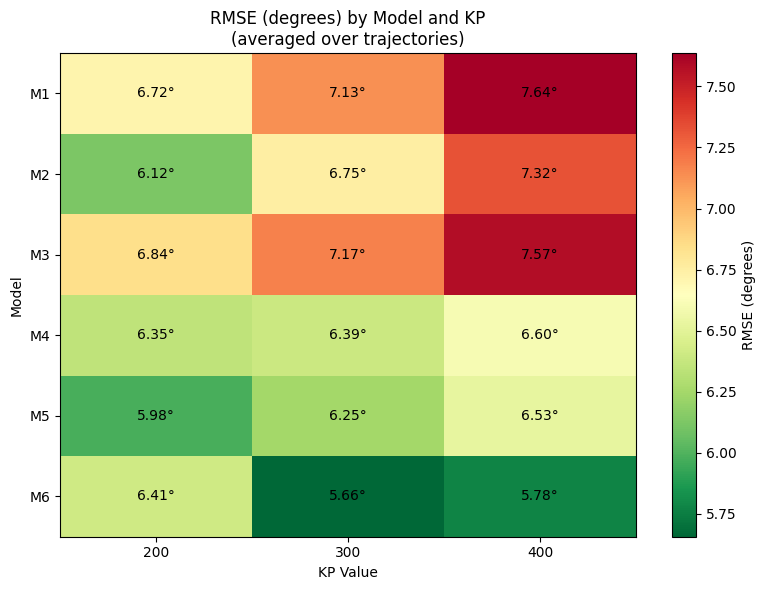

In [81]:
# Heatmap: RMSE by Model vs KP (averaged over trajectory)
pivot_kp = df.pivot_table(values='rmse_deg', index='model', columns='kp', aggfunc='mean')
pivot_kp = pivot_kp.reindex(['M1', 'M2', 'M3', 'M4', 'M5', 'M6'])

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(pivot_kp.values, cmap='RdYlGn_r', aspect='auto')
ax.set_xticks(range(len(pivot_kp.columns)))
ax.set_xticklabels(pivot_kp.columns)
ax.set_yticks(range(len(pivot_kp.index)))
ax.set_yticklabels(pivot_kp.index)
ax.set_xlabel('KP Value')
ax.set_ylabel('Model')
ax.set_title('RMSE (degrees) by Model and KP\n(averaged over trajectories)')

for i in range(len(pivot_kp.index)):
    for j in range(len(pivot_kp.columns)):
        val = pivot_kp.values[i, j]
        ax.text(j, i, f'{val:.2f}°', ha='center', va='center', fontsize=10)

plt.colorbar(im, label='RMSE (degrees)')
plt.tight_layout()
plt.show()

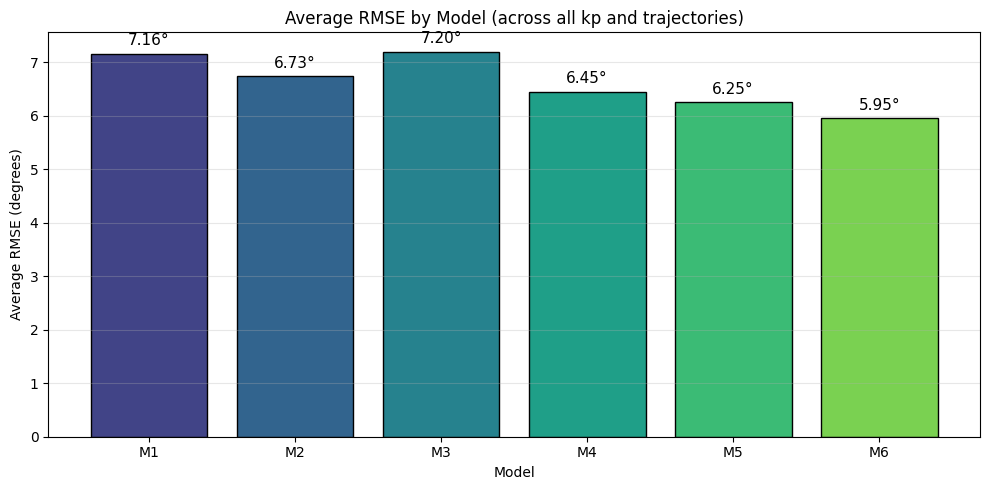

In [82]:
# Bar chart: Average RMSE per Model
model_avg = df.groupby('model')['rmse_deg'].mean().reindex(['M1', 'M2', 'M3', 'M4', 'M5', 'M6'])

fig, ax = plt.subplots(figsize=(10, 5))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 6))
bars = ax.bar(model_avg.index, model_avg.values, color=colors, edgecolor='black')

for bar, val in zip(bars, model_avg.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{val:.2f}°', 
            ha='center', va='bottom', fontsize=11)

ax.set_xlabel('Model')
ax.set_ylabel('Average RMSE (degrees)')
ax.set_title('Average RMSE by Model (across all kp and trajectories)')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

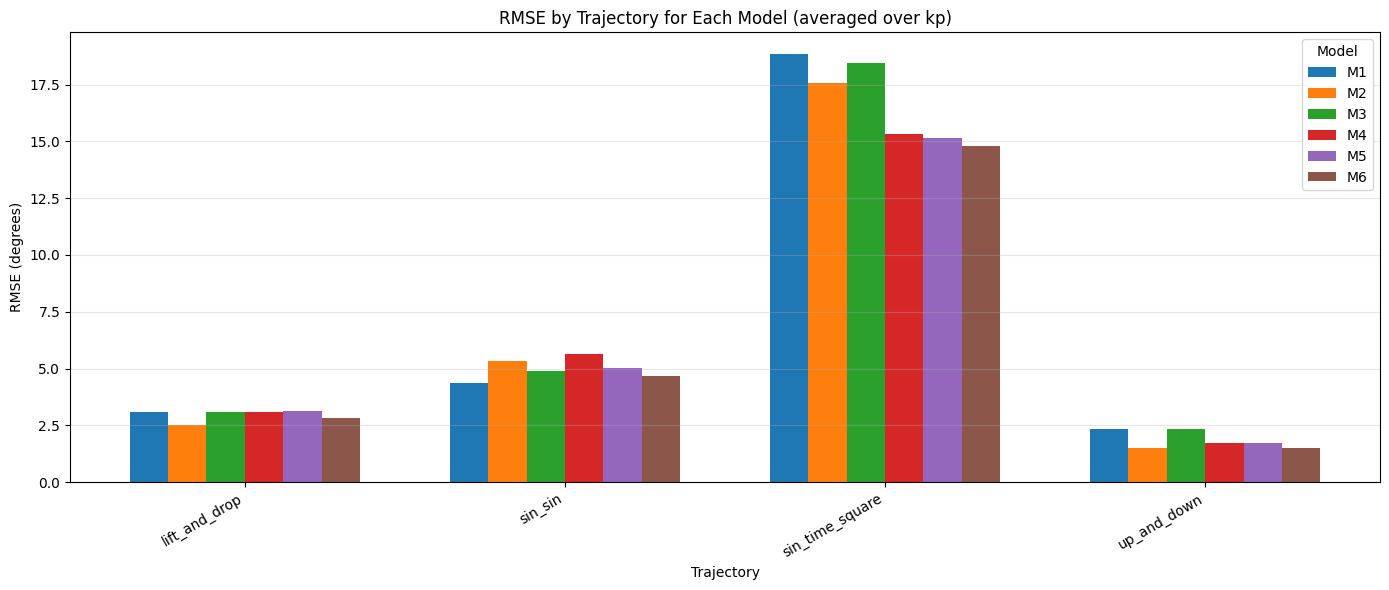

In [83]:
# Grouped bar chart: RMSE by Model for each Trajectory
fig, ax = plt.subplots(figsize=(14, 6))

trajectories = all_trajectories
model_names = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6']
x = np.arange(len(trajectories))
width = 0.12
colors = plt.cm.tab10(np.arange(6))

for i, model in enumerate(model_names):
    model_data = df[df['model'] == model]
    vals = [model_data[model_data['trajectory'] == t]['rmse_deg'].mean() for t in trajectories]
    ax.bar(x + i*width, vals, width, label=model, color=colors[i])

ax.set_xlabel('Trajectory')
ax.set_ylabel('RMSE (degrees)')
ax.set_title('RMSE by Trajectory for Each Model (averaged over kp)')
ax.set_xticks(x + width * 2.5)
ax.set_xticklabels(trajectories, rotation=30, ha='right')
ax.legend(title='Model')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

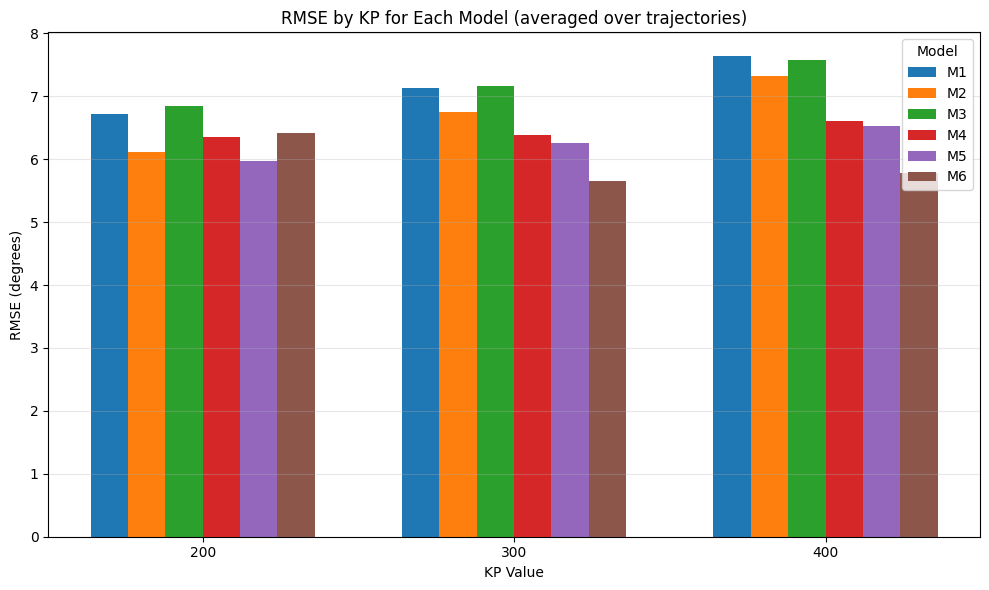

In [84]:
# Grouped bar chart: RMSE by Model for each KP
fig, ax = plt.subplots(figsize=(10, 6))

kps = all_kps
x = np.arange(len(kps))
width = 0.12

for i, model in enumerate(model_names):
    model_data = df[df['model'] == model]
    vals = [model_data[model_data['kp'] == k]['rmse_deg'].mean() for k in kps]
    ax.bar(x + i*width, vals, width, label=model, color=colors[i])

ax.set_xlabel('KP Value')
ax.set_ylabel('RMSE (degrees)')
ax.set_title('RMSE by KP for Each Model (averaged over trajectories)')
ax.set_xticks(x + width * 2.5)
ax.set_xticklabels(kps)
ax.legend(title='Model')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [85]:
# Summary table
print("\n" + "="*70)
print("SUMMARY: Best performing models")
print("="*70)

# Best model overall
best_overall = model_avg.idxmin()
print(f"\nBest model overall: {best_overall} (avg RMSE: {model_avg[best_overall]:.3f}°)")

# Best model per trajectory
print("\nBest model per trajectory:")
for traj in all_trajectories:
    traj_data = df[df['trajectory'] == traj].groupby('model')['rmse_deg'].mean()
    best = traj_data.idxmin()
    print(f"  {traj}: {best} ({traj_data[best]:.3f}°)")

# Best model per kp
print("\nBest model per KP:")
for kp in all_kps:
    kp_data = df[df['kp'] == kp].groupby('model')['rmse_deg'].mean()
    best = kp_data.idxmin()
    print(f"  kp={kp}: {best} ({kp_data[best]:.3f}°)")


SUMMARY: Best performing models

Best model overall: M6 (avg RMSE: 5.949°)

Best model per trajectory:
  lift_and_drop: M2 (2.527°)
  sin_sin: M1 (4.359°)
  sin_time_square: M6 (14.807°)
  up_and_down: M6 (1.506°)

Best model per KP:
  kp=200: M5 (5.976°)
  kp=300: M6 (5.657°)
  kp=400: M6 (5.776°)


---
## M1 - Coulomb Friction Model

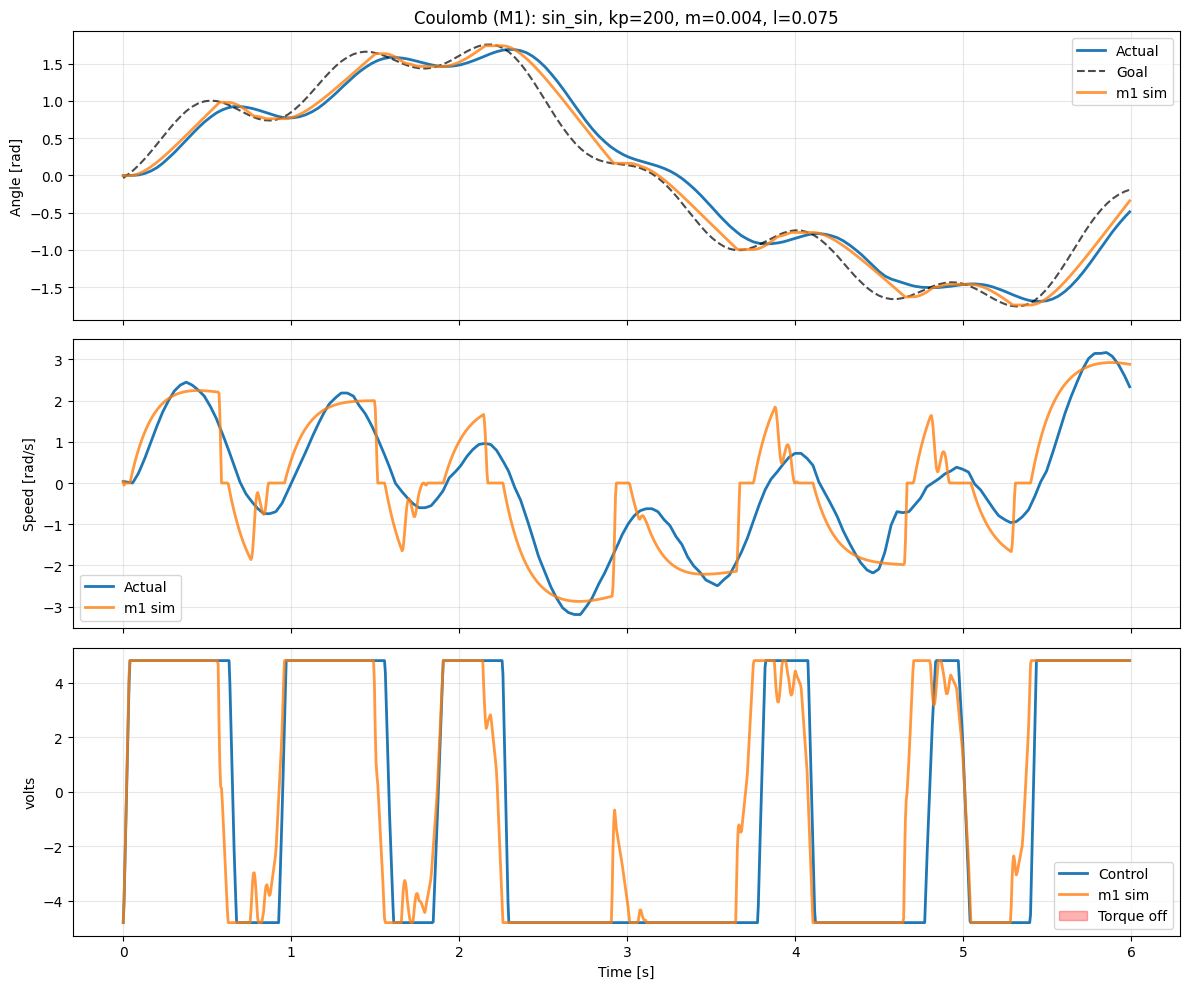

RMSE: 0.1038 rad | MAE: 0.0853 rad


In [86]:
# === EDIT THESE VALUES ===
kp = 200                           # Options: 200, 300, 400
trajectory = "sin_sin"             # Options: lift_and_drop, sin_sin, sin_time_square, up_and_down
params_file = "output/params_1.json"  # M1 files: params_1.json, params_2.json, params_3.json
# =========================

log = get_log(kp, trajectory)
model = load_model(params_file)
if log: plot_model(log, model)

---
## M2 - Stribeck Friction Model

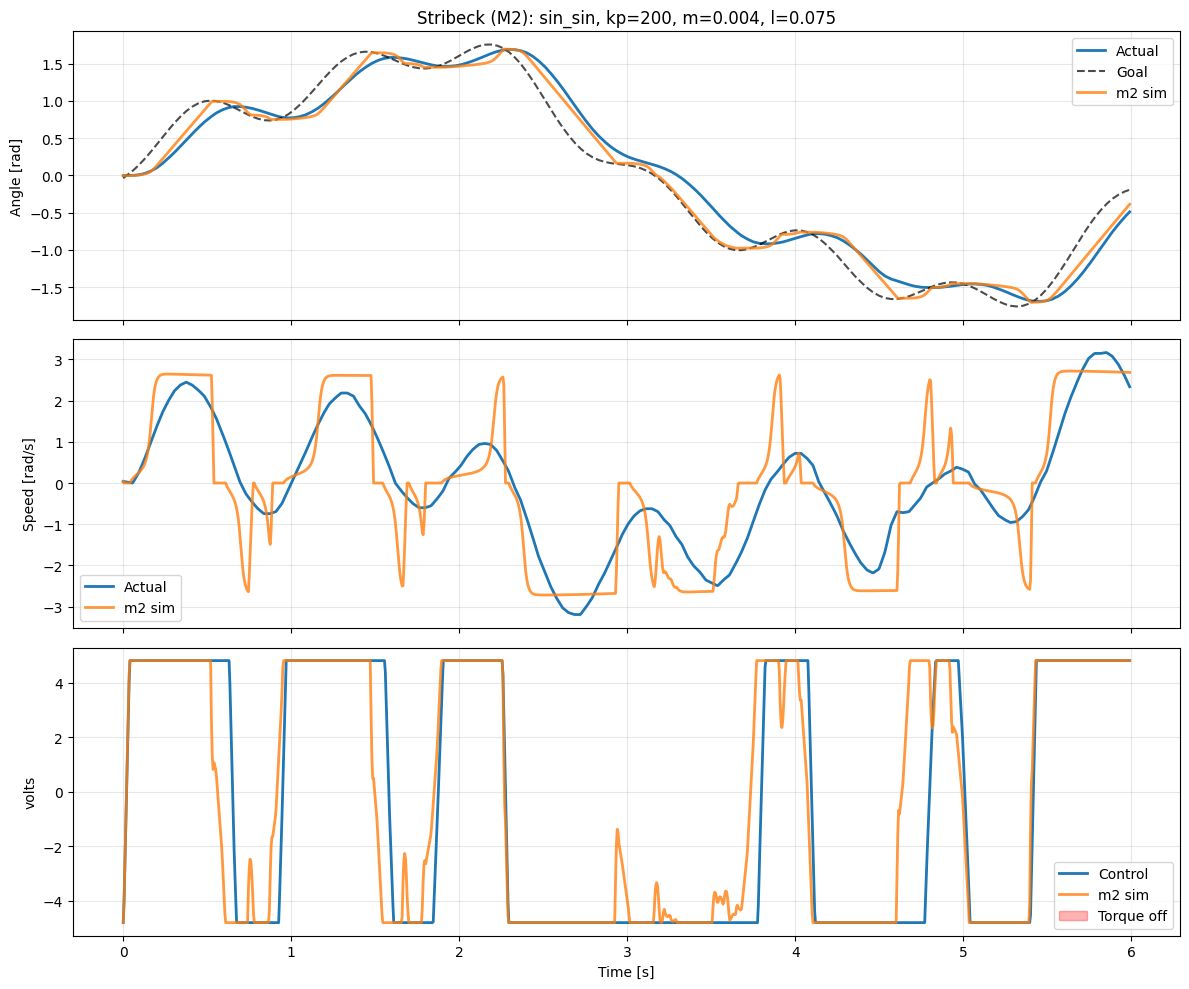

RMSE: 0.1193 rad | MAE: 0.0870 rad


In [87]:
# === EDIT THESE VALUES ===
kp = 200
trajectory = "sin_sin"
params_file = "output/params_4.json"  # M2 files: params_4.json, params_5.json, params_6.json
# =========================

log = get_log(kp, trajectory)
model = load_model(params_file)
if log: plot_model(log, model)

---
## M3 - Load-Dependent Friction Model

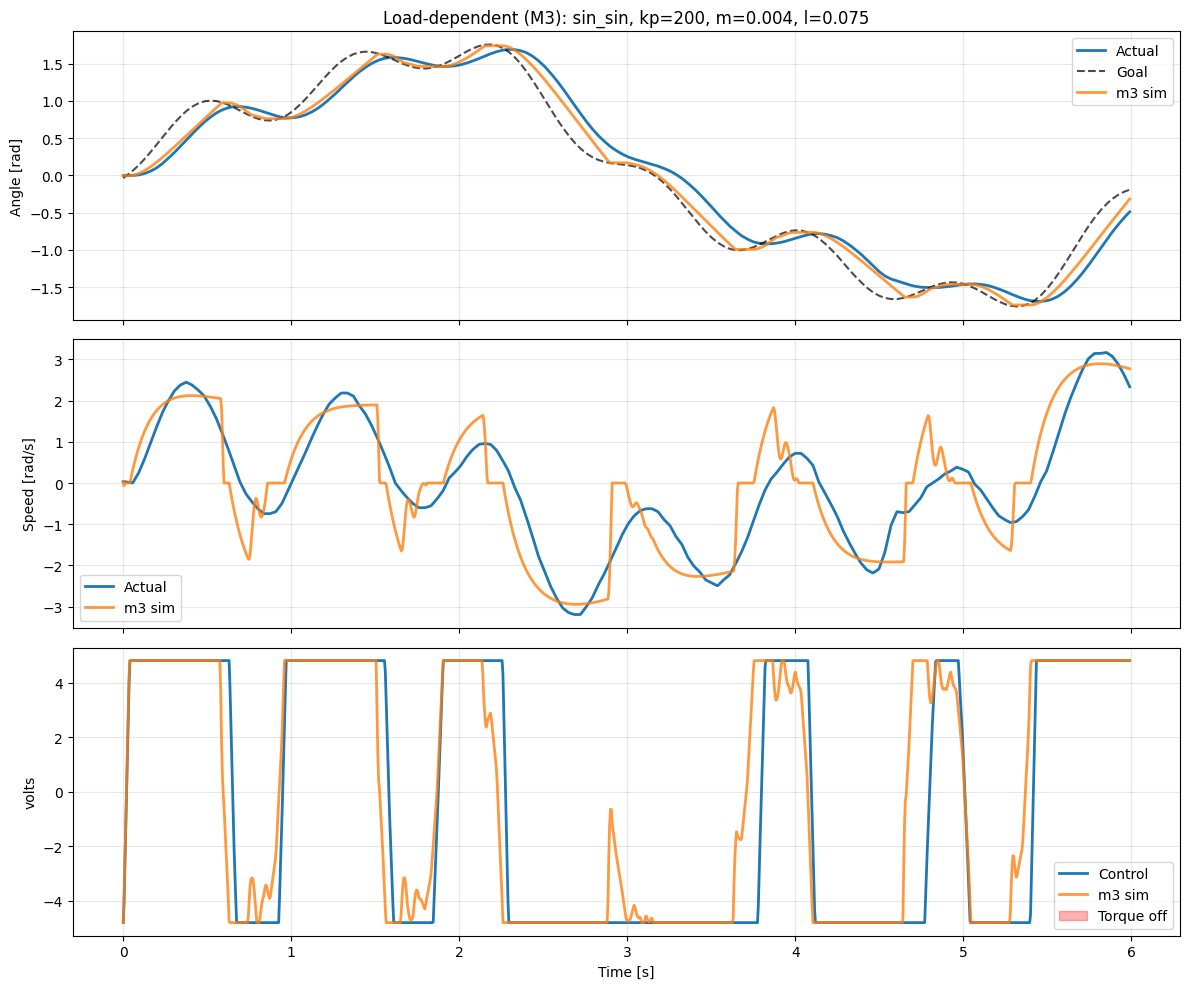

RMSE: 0.1154 rad | MAE: 0.0926 rad


In [88]:
# === EDIT THESE VALUES ===
kp = 200
trajectory = "sin_sin"
params_file = "output/params_7.json"  # M3 files: params_7.json, params_8.json, params_9.json
# =========================

log = get_log(kp, trajectory)
model = load_model(params_file)
if log: plot_model(log, model)

---
## M4 - Stribeck + Load-Dependent Friction Model

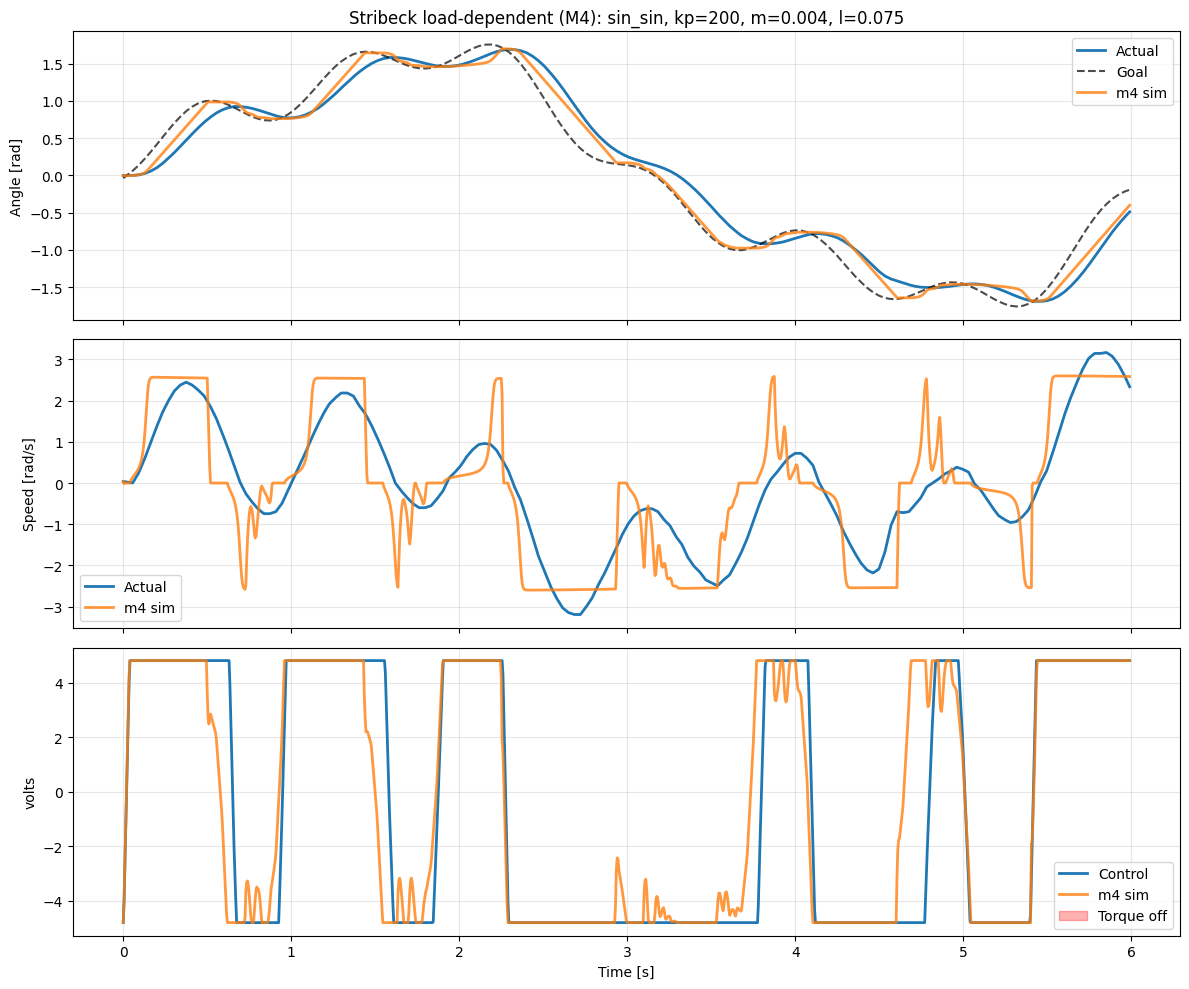

RMSE: 0.1284 rad | MAE: 0.0973 rad


In [89]:
# === EDIT THESE VALUES ===
kp = 200
trajectory = "sin_sin"
params_file = "output/params_10.json"  # M4 files: params_10.json, params_11.json, params_12.json
# =========================

log = get_log(kp, trajectory)
model = load_model(params_file)
if log: plot_model(log, model)

---
## M5 - Stribeck + Load-Dependent + Directional Friction Model

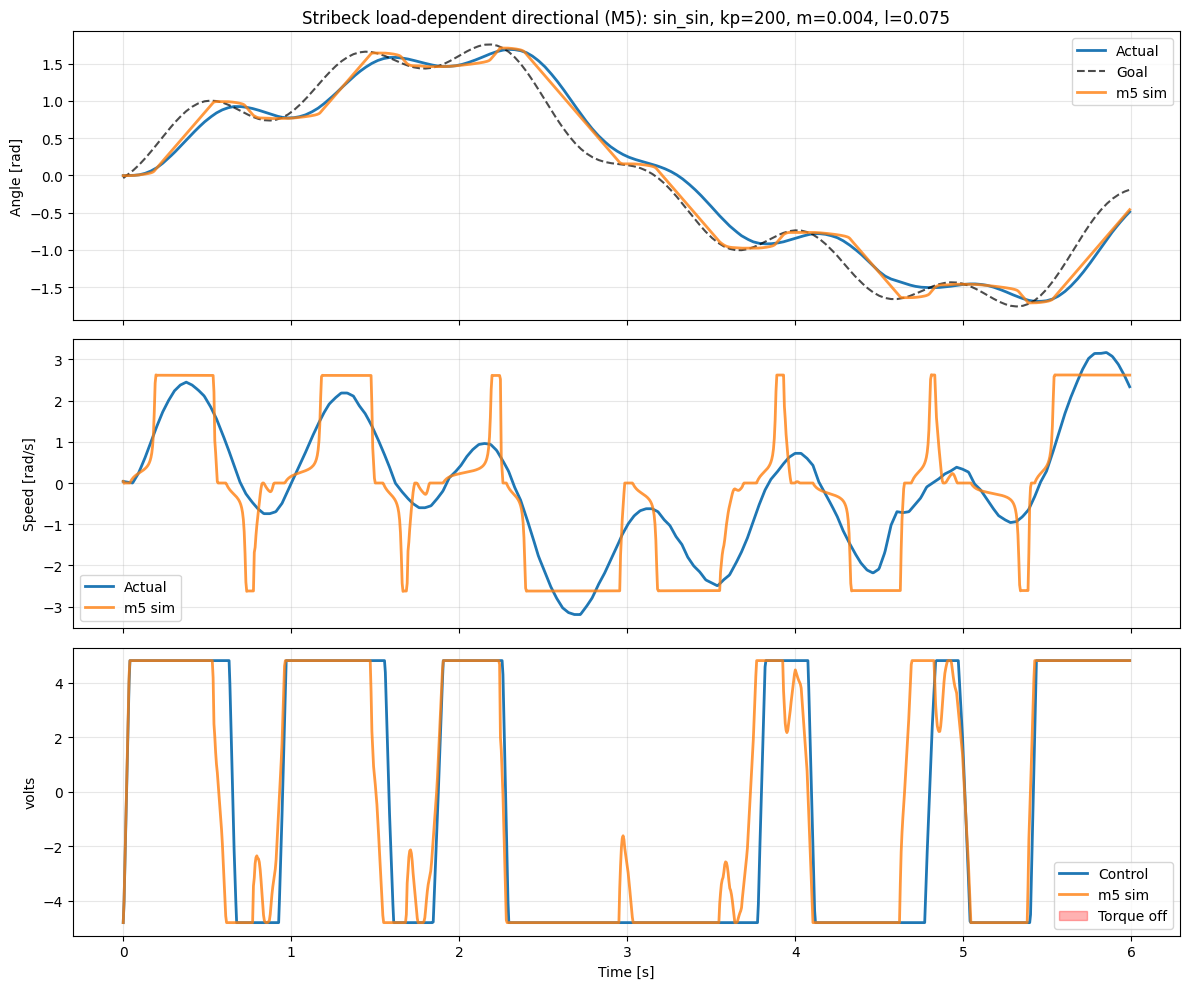

RMSE: 0.1039 rad | MAE: 0.0721 rad


In [90]:
# === EDIT THESE VALUES ===
kp = 200
trajectory = "sin_sin"
params_file = "output/params_13.json"  # M5 files: params_13.json, params_14.json, params_15.json
# =========================

log = get_log(kp, trajectory)
model = load_model(params_file)
if log: plot_model(log, model)

---
## M6 - Full Friction Model (Stribeck + Load-Dependent + Directional + Quadratic)

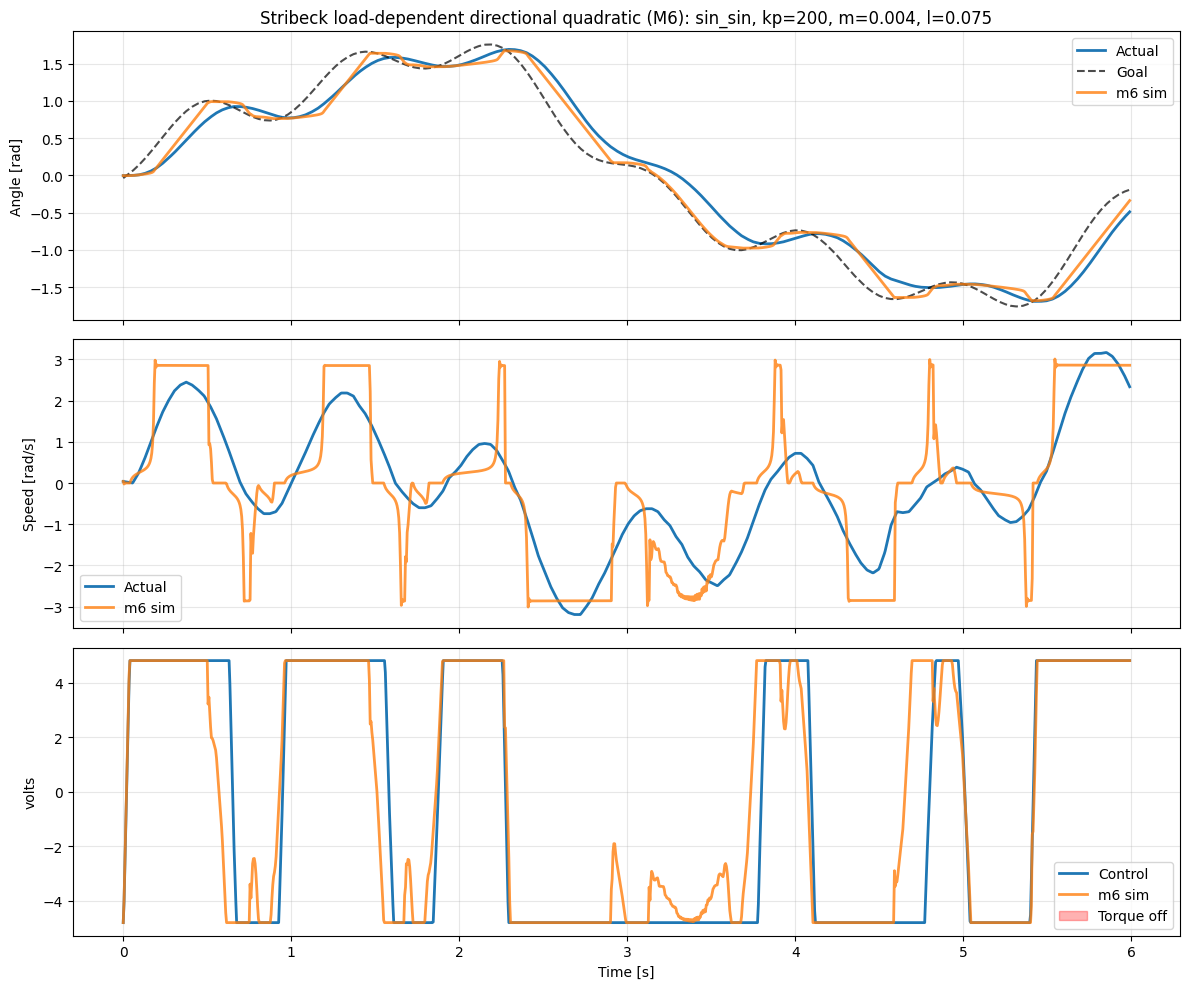

RMSE: 0.1258 rad | MAE: 0.0923 rad


In [91]:
# === EDIT THESE VALUES ===
kp = 200
trajectory = "sin_sin"
params_file = "output/params_16.json"  # M6 files: params_16.json, params_17.json, params_18.json
# =========================

log = get_log(kp, trajectory)
model = load_model(params_file)
if log: plot_model(log, model)

---
## Model Parameters Summary

In [92]:
for model_name in ['m1', 'm2', 'm3', 'm4', 'm5', 'm6']:
    params_files = sorted(glob.glob(f"{OUTPUT_DIR}/params_*.json"))
    matching = [pf for pf in params_files if json.load(open(pf)).get('model') == model_name]
    if matching:
        print(f"\n{'='*60}")
        print(f"{model_name.upper()} - {models[model_name]().title}")
        print(f"{'='*60}")
        for pf in matching:
            data = json.load(open(pf))
            print(f"\n{pf}:")
            for k, v in data.items():
                if k not in ['model', 'actuator']:
                    print(f"  {k}: {v:.6f}" if isinstance(v, float) else f"  {k}: {v}")


M1 - Coulomb (M1)

output/params_1.json:
  kt: 0.162693
  R: 3.690801
  armature: 0.001003
  q_offset: -0.099379
  friction_base: 0.193159
  friction_viscous: 0.000288

output/params_2.json:
  kt: 0.156240
  R: 3.575981
  armature: 0.001039
  q_offset: -0.092019
  friction_base: 0.192194
  friction_viscous: 0.000001

output/params_3.json:
  kt: 0.142060
  R: 3.096175
  armature: 0.001044
  q_offset: -0.083266
  friction_base: 0.200000
  friction_viscous: 0.001839

M2 - Stribeck (M2)

output/params_4.json:
  kt: 0.283451
  R: 3.428171
  armature: 0.001245
  q_offset: 0.064616
  friction_base: 0.194179
  friction_stribeck: 0.192357
  dtheta_stribeck: 1.050493
  alpha: 1.840455
  friction_viscous: 0.052816

output/params_5.json:
  kt: 0.360713
  R: 4.484384
  armature: 0.001015
  q_offset: 0.068509
  friction_base: 0.192999
  friction_stribeck: 0.168979
  dtheta_stribeck: 1.106469
  alpha: 2.997648
  friction_viscous: 0.041442

output/params_6.json:
  kt: 0.360138
  R: 4.558386
  armatur